In [2]:
import time
import numpy as np
import networkx as nx
from utils.dotdict import dotdict
import matplotlib.pyplot as plt
from numba import jit

import itertools
import multiprocessing

from utils.graph_generator import get_graph
from utils.params import init_graph, get_centrum
from utils.params import GIRG_args1,GIRG_args2,GIRG_args3,GIRG_args4, get_moving

from scripts.awareness.agent_country import Agent_Country

In [108]:
args = dotdict({
    "logfile": "../log/GIRG.log",
    "plot": False,
    "max_iteration": 1000,
    "beta_super":0.0,
    "xi": 1,
    "p_teleport":0.0,
    "MAX_E_TIME":10,
    "MAX_I_TIME":10,
    "super_infected_agents": [],
    "p_super": 0.0,
    "awM": None,
    "awR": -1,
    "random_seed":0,
    "CPU_cores":15,
    "simnum":10,
})

In [109]:
import networkx as nx
import matplotlib.pyplot as plt


def plot_layers(graph, r):
    plt.figure(figsize=(5, 5))
    x,y = 1.6,0.1
    pos_dict = nx.get_node_attributes(graph, "pos")
    pos = {k:((p[1]*x+p[0]),y*p[1]) for k,p in pos_dict.items()}
    nx.draw(graph, pos=pos, node_size=10)
    
    pos = {k:((p[1]*x+p[0]),y*p[1]+1) for k,p in pos_dict.items()}
    nx.draw(graph, pos=pos, node_size=10, node_color='r')
    
    pos = {k:((p[1]*x+p[0]),y*p[1]+2) for k,p in pos_dict.items()}
    nx.draw(graph, pos=pos, node_color='g',
           nodelist=graph.nodes, node_size=[i for i,n in enumerate(graph.nodes)])
    plt.show()

In [110]:
n=10
graph = get_graph("grid", {"n": n*n, "N": -1, "d": 4})

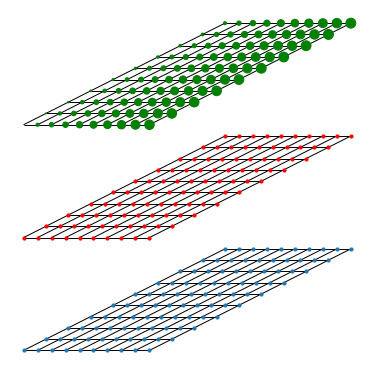

In [111]:
plot_layers(graph, 0)

In [151]:
def run(args, graph, inf, beta, gamma, n, awM, random_seed=0):
    args = dotdict(args)
    
    args["infected_agents"]=inf
    args["beta"]=beta
    args["gamma"]=gamma
    args["awM"] = awM


    res = np.zeros(shape=(args["max_iteration"], 4))
    seed_hist = np.zeros(shape=(args["max_iteration"], len(graph)))

    country = Agent_Country(args, graph)
    country.init_seeds = args["infected_agents"]
    Agent_Country.numba_random_seed(random_seed)
    country.log_json()
    for i in range(args["max_iteration"]):
        res[i,2]=np.sum(country.states ==2)
        seed_hist[i] = country.seed
        
        if country.check_stop():
            #break
            pass
        country.step()
        country.log_json()

    return res[:i,2], seed_hist

In [203]:
n=10
initialy_infected = 10
args["max_iteration"]=30
inf=list(np.random.randint(0,len(graph),initialy_infected))
#inf=[n**2//2+n//2]


graph = get_graph("grid", {"n": n*n, "N": -1, "d": 4})
Is, seed_hist = run(args, graph, inf, 0.6, 0.3, 10, 0.1, 0)

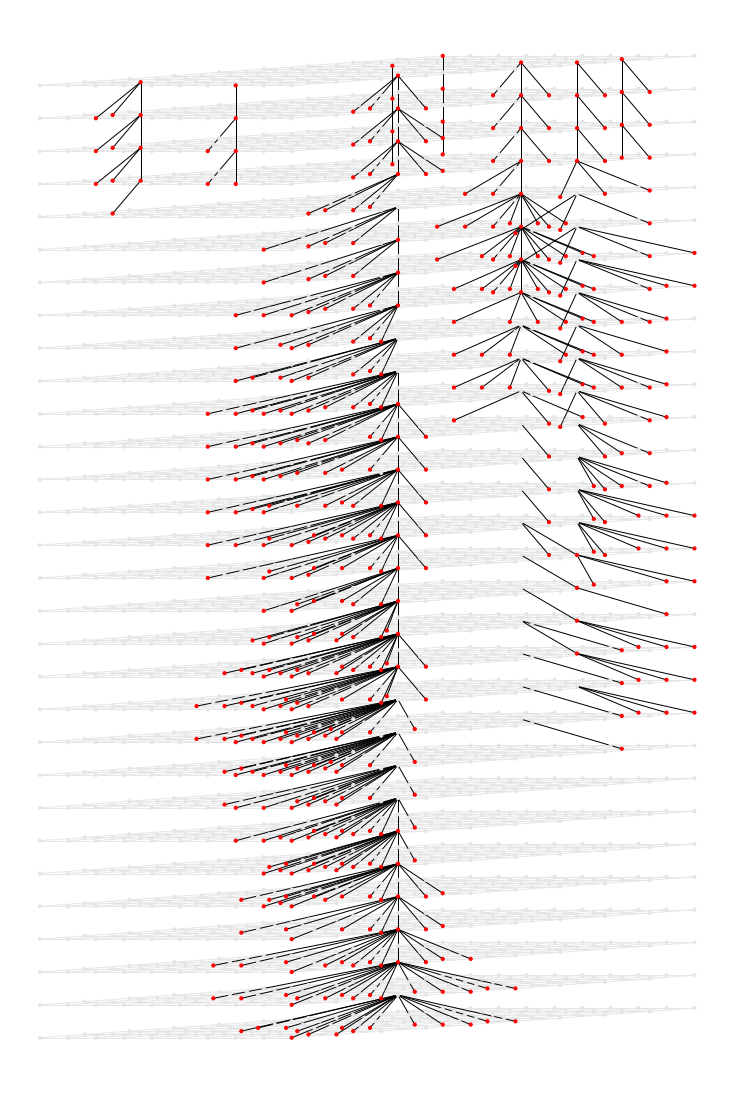

In [213]:
plt.figure(figsize=(10, 15))

pos_dict = nx.get_node_attributes(graph, "pos")
node_indexes = nx.get_node_attributes(graph, "index")
node_from_index = {i:n for n,i in indexes.items()}

G=nx.Graph()

for i in range(args["max_iteration"]):
    x,y = 1.6,0.1
    pos = {k:((p[1]*x+p[0]),y*p[1]-i) for k,p in pos_dict.items()}
        
    # Add nodes of the multi-layer graph
    for n in graph.nodes:
        G.add_node((n,i))
        G.nodes[(n,i)]["pos"]=pos[n]
    
    # Add edges of the multi layer graph
    parents = seed_hist[i][seed_hist[i]!=-1]
    inf_indx = np.arange(0,len(graph))[seed_hist[i]!=-1]
    for n_i,p_i in zip(inf_indx, parents):
        n = node_from_index[n_i]
        p = node_from_index[p_i]
        if(i-1 >= 0):
            G.add_edge((n,i),(p,i-1))

    node_list = graph.nodes
    node_color = [('r' if (node_indexes[n] in inf_indx) else (0.9,0.9,0.9)) for n in graph.nodes]
    
    nx.draw(graph, pos=pos, node_size=10, node_color=node_color, edge_color=(0.9,0.9,0.9))

pos_multi = nx.get_node_attributes(G,"pos")
nx.draw_networkx_edges(G, pos = pos_multi, edgelist=G.edges)
plt.show()